# Logistic Regression with Real Data set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
from sklearn import preprocessing
from scipy.stats import multivariate_normal

In [2]:
data = pd.read_csv('page-blocks.data', delim_whitespace=True, header=None)

In [3]:
# Select first 10 variables
y = (data[10] == 1).astype(np.float64)
X = np.array(data[list(range(0,4))], np.float64)
XX = preprocessing.scale(X)

y = y[:3500]
XX = XX[:3500,:]
Sigma_beta = np.eye(4).astype(np.float64)

# HMC
## Potential Energy Function $U$ and $\nabla U$ (vectorized):
Likelihood function, Potential Energy Function and its gradient are as follows:
$$L(\vec{y};\theta_0,\dots \theta_{10}) = \prod_{i}\frac{e^{(X_i \cdot \vec{\theta})y_i}}{1 + e^{X_i \cdot \vec{\theta}}}$$
    \begin{align*}
    U = -log(p(\vec\theta|\vec{y})) &= -\sum_{i} (X_i\vec{\theta}y_i - log(1 + e^{X_i \cdot \vec{\theta}})) - log(\text{dnorm}_k(\vec{\theta}; \vec{0}_k,I_k))\\
    \nabla U &= -\sum_{i} (X_i(y_i - \frac{e^{X_i\vec\theta}}{1+e^{X_i\vec\theta}})) +\vec\theta
    \end{align*}
   

In [4]:
def U(theta, X, y, Sigma_beta):
    return (-np.sum(X @ theta * y - np.log(1+np.exp(X @ theta))) - np.log(multivariate_normal.pdf(theta, np.zeros(4), Sigma_beta)))

In [5]:
def gradU(theta, X, y, Sigma_beta):
    return ( -(np.sum(X * y[:,None] - X * (np.exp(X @ theta) / (1 + np.exp(X @ theta)))[:,None] ,0)) +
            np.linalg.inv(Sigma_beta) @ theta )

In [6]:
def hmc_vector(U, gradU, m, dt, nstep, x, X, y, Sigma_beta):
    mean = np.zeros_like(x)
    p = np.random.multivariate_normal(mean, m)
    oldX = x.copy()
    oldEnergy = 0.5 * p.dot(np.linalg.solve(m, p))  + U(x, X, y, Sigma_beta)
    for i in range(nstep):
        p -= gradU(x, X, y, Sigma_beta) * dt/2.
        x += np.linalg.solve(m, p) * dt
        p -= gradU(x, X, y, Sigma_beta) * dt/2.
    newEnergy = 0.5 * p.dot(np.linalg.solve(m, p))  + U(x, X, y, Sigma_beta)
    if np.random.random() > np.exp(oldEnergy - newEnergy): # Metropolis-Hastings
        x = oldX.copy()
    return x.copy()

In [7]:
nsample = 5000
bb = np.zeros(4)
m = np.eye(4)
dt = 0.01
nstep = 10

In [8]:
%%time
samples_hmc = []
for i in range(nsample):
    bb = hmc_vector(U, gradU, m, dt, nstep, bb, XX, y, Sigma_beta)
    samples_hmc.append(bb)

CPU times: user 1min 5s, sys: 56 ms, total: 1min 5s
Wall time: 1min 5s


In [9]:
samples_hmc = np.array(samples_hmc)
hmc_samples_mean = samples_hmc[1000:].mean(axis=0)

# SGHMC (new)

In [12]:
size = 0.2
# with 20% of data, we are using 700 observations.

nsample = 5000
V = 1
etaSGHMC = 0.0001
alpha = 0.0001
L = 5

s = XX.shape[0] / round(XX.shape[0]*size)

In [13]:
def sg_gradU(theta, X, y, Sigma_beta, size = s):
    return s * ( -(np.sum(X * y[:,None] - X * (np.exp(X @ theta) / (1 + np.exp(X @ theta)))[:,None] ,0)) +
            np.linalg.inv(Sigma_beta) @ theta )

In [14]:
def sghmc_vectorNew(gradU, eta, L, alpha, x, V, XX, y, Sigma_beta, size):
    beta = 0.5 * V * eta
    p = np.random.randn(len(x)) * np.sqrt( eta )
    momentum = 1. - alpha
    try:
        sigma = np.sqrt( 2. * eta * (alpha-beta) )
    except:
        print('eta too big')
    for i in range(L):
        p = p * momentum - gradU( x, Xb, yb, Sigma_beta, size ) * eta + np.random.randn(len(p)) * sigma
        x += p
    return x.copy()

In [15]:
%%time
samples = []
Xdim = XX.shape[0]
bb = np.ones(4) * 0
for i in range(nsample):
    # Making Mini Batches
    idx = np.random.choice(Xdim, round(Xdim*size), replace = False)
    Xb = XX[idx,:]
    yb = y[idx]
    bb = sghmc_vectorNew(sg_gradU, etaSGHMC, L, alpha, bb, V, Xb, yb, Sigma_beta, s)
    samples.append(bb.copy())

CPU times: user 24.2 s, sys: 36 ms, total: 24.2 s
Wall time: 24.4 s


## Collecting Results

In [16]:
samples = np.array(samples)
sg_samples_mean = np.mean(samples[1000:,],0)
print(hmc_samples_mean)
print(sg_samples_mean)

[ -4.19738068   6.22772382  -5.98301849 -12.57134441]
[-3.42883667  3.38317682 -2.95796703 -8.28250656]


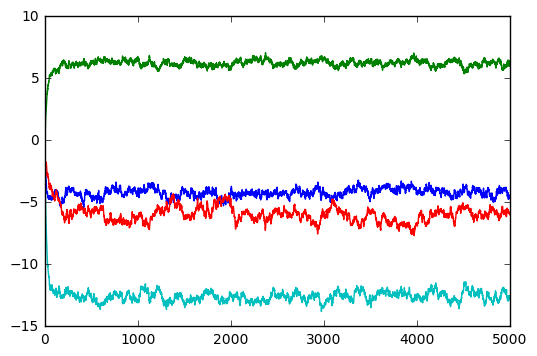

In [17]:
plt.plot(np.array(samples_hmc)[:,0])
plt.plot(np.array(samples_hmc)[:,1])
plt.plot(np.array(samples_hmc)[:,2])
plt.plot(np.array(samples_hmc)[:,3])

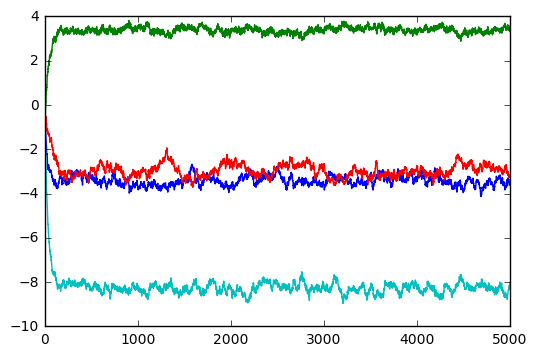

In [18]:
plt.plot(np.array(samples)[:,0])
plt.plot(np.array(samples)[:,1])
plt.plot(np.array(samples)[:,2])
plt.plot(np.array(samples)[:,3])

## Comparing Values with JAGS
Since it was not able to install the package named "R2jags", we ran this code in R.

In [10]:
%load_ext rpy2.ipython

In [11]:
#%%R -i XX y
#
#library(R2jags)
#dat = read.table('page-blocks.data',header=F)
#
#
#jags_data = list(Y = y,
#                 X = XX,
#                 n = length(y),
#                 p = ncol(XX))
#
#jags.model = "model {
#  
#  for (i in 1:n) {
#    logit(mu[i]) = inprod(X[i,], theta)
#    Y[i] ~ dbern(mu[i])
#  }
#  
#  for (j in 1:(p)){
#    theta[j] ~ dnorm(0,1)
#  }
#}
#"
#
#parameters = "theta"
#
#jags_sim = jags(jags_data, inits=NULL, 
#                parameters.to.save=parameters,
#                model.file=textConnection(jags.model),
#                n.iter=10000)
#
#jags_sim

```
Inference for Bugs model at "3", fit using jags,
 3 chains, each with 5000 iterations (first 2500 discarded), n.thin = 2
 n.sims = 3750 iterations saved
          mu.vect sd.vect     2.5%      25%      50%      75%    97.5%  Rhat n.eff
theta[1]   -4.231   0.495   -4.947   -4.511   -4.263   -4.026   -3.138 1.025    97
theta[2]    5.980   0.676    4.262    5.878    6.090    6.307    6.728 1.023   100
theta[3]   -5.364   1.362   -7.207   -6.293   -5.538   -4.943   -1.305 1.072    36
theta[4]  -12.399   0.860  -13.200  -12.773  -12.510  -12.207  -11.189 1.001  3800
deviance 1400.857 140.217 1345.529 1365.351 1377.930 1393.322 1610.026 1.003   740

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 9821.9 and DIC = 11222.7
DIC is an estimate of expected predictive error (lower deviance is better).
```